Avant de lancer ce NB, je lance le terminal Anaconda et je copie colle : 
mlflow server --host 127.0.0.1 --port 8080 

Ca lance MLFlow

In [165]:
import mlflow
from mlflow.tracking import MlflowClient

from PIL import Image
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import time
from scipy.special import expit  # La fonction logistique

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, roc_auc_score, f1_score, fbeta_score, recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler

import imblearn
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

import lightgbm as lgb

from mlflow.models import infer_signature
from lightgbm import early_stopping

import shap
# Memory management
import gc 

import streamlit as st

In [166]:
# démarrage du tracking
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")

In [167]:
# Vérifiez que le serveur MLflow est accessible
try:
    mlflow.get_experiment_by_name("MLflow Credit_Scoring - Projet_7")
    print("Le serveur MLflow est accessible.")
except Exception as e:
    print(f"Erreur de connexion au serveur MLflow: {e}")

Le serveur MLflow est accessible.


# 10 - Nouvelle modélisation après suppression des variables 'driftées'
--------

In [168]:
train_reduced=pd.read_csv('train_reduced.csv')

In [169]:
train_reduced.head()

,EXT_SOURCE_1,CREDIT_TERM,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,DAYS_EMPLOYED,client_installments_AMT_PAYMENT_min_sum,AMT_ANNUITY,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_ENDDATE_max,...,client_installments_NUM_INSTALMENT_NUMBER_min_max,ORGANIZATION_TYPE_Business Entity Type 3,previous_NAME_CASH_LOAN_PURPOSE_XNA_sum,previous_CODE_REJECT_REASON_LIMIT_mean,previous_NAME_SELLER_INDUSTRY_Construction_mean,FLAG_DOCUMENT_16,NAME_INCOME_TYPE_Working,previous_NAME_GOODS_CATEGORY_Sport and Leisure_mean,TARGET,SK_ID_CURR
0,0.083037,0.060749,0.262949,0.139376,9461,-637.0,175783.73,24700.5,-103.0,780.0,...,1.0,True,0.0,0.000000,0.000000,0,True,0.0,1,100002
1,0.311267,0.027598,0.622246,NaN,16765,-1188.0,1154108.20,35698.5,-606.0,1216.0,...,1.0,False,1.0,0.000000,0.000000,0,False,0.0,0,100003
2,NaN,0.050000,0.555912,0.729567,19046,-225.0,16071.75,6750.0,-408.0,-382.0,...,1.0,False,0.0,0.000000,0.000000,0,True,0.0,0,100004
3,NaN,0.094941,0.650442,NaN,19005,-3039.0,994476.70,29686.5,NaN,NaN,...,1.0,True,5.0,0.111111,0.111111,0,True,0.0,0,100006
4,NaN,0.042623,0.322738,NaN,19932,-3038.0,483756.38,21865.5,-1149.0,-783.0,...,1.0,False,4.0,0.000000,0.000000,0,True,0.0,0,100007


In [170]:
test_reduced=pd.read_csv('test_reduced.csv')

In [171]:
train_reduced.shape, test_reduced.shape

((307511, 346), (48744, 345))

In [172]:
train_reduced=train_reduced.drop(['AMT_CREDIT', 'AMT_ANNUITY', 'CREDIT_TERM'], axis=1)
test_reduced=test_reduced.drop(['AMT_CREDIT', 'AMT_ANNUITY', 'CREDIT_TERM'], axis=1)

In [173]:
train_reduced.shape, test_reduced.shape

((307511, 343), (48744, 342))

In [174]:
train_reduced['TARGET'].value_counts()

TARGET
0    282686
1     24825
Name: count, dtype: int64

In [175]:
train_reduced['NAME_EDUCATION_TYPE_Higher education'].unique()

array([False,  True])

In [176]:
test_reduced['NAME_EDUCATION_TYPE_Higher education'].unique()

array([ True, False])

## 10.1 - Préparation des données

In [177]:
# Séparation du set de train en train / val
train_r, val_r = train_test_split(train_reduced, test_size=0.2, random_state=42)

# Extraction des identifiants, de la target et des variables explicatives pour les ensembles d'entraînement et de test
X_train_r = train_r.drop(['SK_ID_CURR', 'TARGET'], axis=1)
y_train_r = train_r['TARGET']
id_train_r = train_r['SK_ID_CURR']

X_val_r = val_r.drop(['SK_ID_CURR', 'TARGET'], axis=1)
y_val_r = val_r['TARGET']
id_val_r = val_r['SK_ID_CURR']

test_r=test_reduced.drop('SK_ID_CURR', axis=1)
id_test_r = test_reduced['SK_ID_CURR']
    

In [178]:
X_train_r.shape, X_val_r.shape, test_r.shape, y_train_r.shape, y_val_r.shape, id_train_r.shape, id_val_r.shape, id_test_r.shape

((246008, 341),
 (61503, 341),
 (48744, 341),
 (246008,),
 (61503,),
 (246008,),
 (61503,),
 (48744,))

In [179]:
def prepare_modelisation (X_train, X_val, test) :

    # Création du label Encoder
    le = LabelEncoder()
    
    # Label Encoding des variables de type 'object' ayant au max 2 valeurs uniques
    for col in X_train.columns:
        if X_train[col].dtype == 'object' and len(list(X_train[col].unique())) <= 2:
            # Apply the label encoder to both training and test sets
            X_train[col] = le.fit_transform(X_train[col])
            X_val[col] = le.transform(X_val[col])
            test[col] = le.transform(test[col])
           
    # One-hot encoding des variables catégorielles
    X_train = pd.get_dummies(X_train)
    X_val = pd.get_dummies(X_val)
    test = pd.get_dummies(test)
    

    # Assurons-nous que X_train et X_test ont les mêmes colonnes
    X_train, X_val = X_train.align(X_val, join='inner', axis=1)
    X_train, test = X_train.align(test, join='inner', axis=1)
    
   
    # Imputation des MV par la médiane
    imputer = SimpleImputer(strategy = 'median')

    # Min Max Scaling
    scaler = MinMaxScaler(feature_range = (0, 1))

    X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
    X_val = pd.DataFrame(imputer.transform(X_val), columns=X_val.columns)
    test = pd.DataFrame(imputer.transform(test), columns=test.columns)
    
    X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
    X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
    test = pd.DataFrame(scaler.transform(test), columns=test.columns)

   
    return X_train, X_val, test

In [180]:
X_train_r, X_val_r, test_r=prepare_modelisation (X_train_r, X_val_r, test_r)

In [181]:
X_train_r.shape, X_val_r.shape, test_r.shape, y_train_r.shape, y_val_r.shape, id_train_r.shape, id_val_r.shape, id_test_r.shape

((246008, 341),
 (61503, 341),
 (48744, 341),
 (246008,),
 (61503,),
 (246008,),
 (61503,),
 (48744,))

## 10.2 - Consolidation du jeu de test préparé

Reconsitutation du jeu de test à partir des données préparées pour la modélisation + leur ID => nous sauvegarderons ce jeu de test préparé et consolidé qui nous servira à tester notre API de credit scoring

In [182]:
reconstituted_test=pd.concat([id_test_r, test_r], axis=1) 

On ne garde que 10% du jeu de données pq Git n'autorise pas le stockage d'un grand jeu de données

In [183]:
reconstituted_test_sampled = reconstituted_test.sample(frac=0.1, random_state=42)  # random_state pour reproductibilité

In [184]:
reconstituted_test_sampled.head()

,SK_ID_CURR,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,DAYS_EMPLOYED,client_installments_AMT_PAYMENT_min_sum,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_ENDDATE_max,DAYS_ID_PUBLISH,...,client_credit_AMT_INST_MIN_REGULARITY_sum_sum,previous_NAME_GOODS_CATEGORY_Gardening_mean,client_installments_NUM_INSTALMENT_NUMBER_min_max,ORGANIZATION_TYPE_Business Entity Type 3,previous_NAME_CASH_LOAN_PURPOSE_XNA_sum,previous_CODE_REJECT_REASON_LIMIT_mean,previous_NAME_SELLER_INDUSTRY_Construction_mean,FLAG_DOCUMENT_16,NAME_INCOME_TYPE_Working,previous_NAME_GOODS_CATEGORY_Sport and Leisure_mean
15071,208550,0.664307,0.902796,0.599166,0.217531,0.935853,0.055533,0.896988,0.585400,0.450743,...,0.004138,0.0,0.0,1.0,0.000000,0.000000,0.0,0.0,1.0,0.0
10157,173779,0.524898,0.786010,0.619130,0.696900,0.908106,0.033502,0.997262,0.697944,0.550229,...,0.004138,0.0,0.0,0.0,0.068966,0.111111,0.0,0.0,0.0,0.0
36313,365820,0.826955,0.737094,0.691248,0.431172,0.726943,0.090487,0.645791,0.558941,0.381687,...,0.000000,0.0,0.0,1.0,0.068966,0.000000,0.0,0.0,0.0,0.0
6017,144092,0.475811,0.902102,0.457380,0.435457,0.845188,0.092695,0.904860,0.575216,0.313186,...,0.004465,0.0,0.0,0.0,0.068966,0.000000,0.0,0.0,1.0,0.0
26319,291599,0.353510,0.560834,0.599166,0.468828,0.675301,0.033505,0.896988,0.585400,0.174239,...,0.004138,0.0,0.0,0.0,0.068966,0.000000,0.0,0.0,1.0,0.0


In [185]:
reconstituted_test.shape, reconstituted_test_sampled.shape

((48744, 342), (4874, 342))

In [186]:
reconstituted_test['NAME_EDUCATION_TYPE_Higher education'].unique()

array([1., 0.])

In [187]:
reconstituted_test_sampled['NAME_EDUCATION_TYPE_Higher education'].unique()

array([1., 0.])

In [20]:
reconstituted_test_sampled.to_csv('reconstituted_test_sampled.csv', index=False)

# **FONCTION DU NB 1 A SUPPRIMER QUAND ON GROUPERA LES NB**

In [21]:
def custom_f1(y_true, y_pred_proba):
    """
    Calcule le meilleur F1 score pour un modèle de classification binaire en sélectionnant le seuil
    de probabilité qui minimise un coût personnalisé basé sur les faux négatifs et les faux positifs.

    Paramètres :
    -----------
    y_true : array-like
        Vecteur des étiquettes vraies (0 ou 1).

    y_pred_proba : array-like
        Vecteur des probabilités prédites par le modèle pour la classe positive (1).

    Retourne :
    --------
    best_f1 : float
        Le meilleur F1 score obtenu en utilisant le seuil optimal.

    Description :
    ------------
    La fonction parcourt une gamme de seuils de probabilité (de 0 à 1) pour convertir les
    probabilités prédites en étiquettes binaires. Pour chaque seuil, elle calcule le F1 score et
    un coût défini comme suit :
        coût = (nombre de faux négatifs) * 10 + (nombre de faux positifs)
    Le meilleur F1 score est celui obtenu avec le seuil qui minimise ce coût.

    Exemple :
    --------
    >>> y_true = [0, 1, 0, 1, 1]
    >>> y_pred_proba = [0.1, 0.4, 0.35, 0.8, 0.7]
    >>> custom_f1(y_true, y_pred_proba)
    0.6666666666666666
    """
    thresholds = np.linspace(0, 1, 100)
    best_threshold = 0.5
    best_f1 = 0
    best_cost = float('inf')
    
    for threshold in thresholds:
        y_pred = (y_pred_proba >= threshold).astype(int)
        f1 = f1_score(y_true, y_pred)
        # Calculer les coûts
        fn = np.sum((y_true == 1) & (y_pred == 0))
        fp = np.sum((y_true == 0) & (y_pred == 1))
        cost = fn * 10 + fp
        
        # Sélectionner le seuil basé sur le coût le plus bas
        if cost < best_cost:
            best_f1 = f1
            best_threshold = threshold
            best_cost = cost
    
    return best_f1

In [22]:

def custom_recall(y_true, y_pred_proba):
    """
    Calcule le rappel optimal pour une prédiction probabiliste en ajustant le seuil de classification.

    Cette fonction parcourt une gamme de seuils pour déterminer celui qui donne le meilleur rappel
    tout en minimisant un coût défini comme une combinaison des faux négatifs (fn) et des faux positifs (fp).
    Le coût est calculé comme suit : coût = fn * 10 + fp.

    Paramètres:
    y_true (array-like): Les vraies étiquettes de classe.
    y_pred_proba (array-like): Les probabilités prédites pour la classe positive.

    Retourne:
    float: Le meilleur rappel obtenu pour le seuil avec le coût le plus bas.
    """
    thresholds = np.linspace(0, 1, 100)
    best_threshold = 0.5
    best_recall = 0
    best_cost = float('inf')
    
    for threshold in thresholds:
        y_pred = (y_pred_proba >= threshold).astype(int)
        recall = recall_score(y_true, y_pred)
        # Calculer les coûts
        fn = np.sum((y_true == 1) & (y_pred == 0))
        fp = np.sum((y_true == 0) & (y_pred == 1))
        cost = fn * 10 + fp
        
        # Sélectionner le seuil basé sur le coût le plus bas
        if cost < best_cost:
            best_recall = recall
            best_threshold = threshold
            best_cost = cost
    
    return best_recall


In [23]:
def run_grid_search(X_train, y_train, model, param_grid, fit_params=None, train_size=1.0):
    """
    Exécute une recherche en grille avec validation croisée pour optimiser les hyperparamètres d'un modèle de classification,
    en utilisant SMOTE pour équilibrer les classes et des scorers personnalisés.

    Paramètres :
    -----------
    X_train : array-like
        Les caractéristiques d'entraînement.
    
    y_train : array-like
        Les étiquettes d'entraînement.
    
    model : estimator
        Le modèle de classification à optimiser.
    
    param_grid : dict
        Dictionnaire des hyperparamètres à tester pour le modèle. Les clés doivent être les noms des hyperparamètres
        et les valeurs doivent être des listes de valeurs à tester.
    
    fit_params : dict, optionnel
        Paramètres supplémentaires à passer à la méthode `fit` du modèle.
    
    train_size : float, optionnel
        Fraction de l'ensemble d'entraînement à utiliser. La valeur par défaut est 1.0 (utiliser tout l'ensemble d'entraînement).

    Retourne :
    --------
    dict
        Un dictionnaire contenant les informations suivantes :
        - 'best_model' : le meilleur modèle estimé.
        - 'best_params_' : les meilleurs paramètres trouvés.
        - 'best_score_' : le meilleur score obtenu.
        - 'cv_results_' : les résultats détaillés de la validation croisée.

    Description :
    ------------
    Cette fonction effectue une recherche en grille avec validation croisée pour optimiser les hyperparamètres d'un modèle de classification.
    Elle utilise SMOTE pour équilibrer les classes et des scorers personnalisés pour évaluer les performances du modèle. Les scorers utilisés
    sont l'AUC, un F1 score personnalisé et un rappel personnalisé. Le pipeline de traitement comprend SMOTE pour le suréchantillonnage des
    classes minoritaires et le modèle à optimiser.

    Exemple :
    --------
    >>> from sklearn.linear_model import LogisticRegression
    >>> param_grid = {'C': [0.1, 1, 10]}
    >>> results = run_grid_search(X_train, y_train, LogisticRegression(), param_grid)
    >>> print(results['best_params_'])
    {'model__C': 1}

    """
    # Définir les scorers personnalisés
    scorers = {
        'AUC': 'roc_auc',
        'F1_opt': make_scorer(custom_f1, needs_proba=True),
        'recall_opt': make_scorer(custom_recall, needs_proba=True)
    }

    # Créer un pipeline avec SMOTE et le modèle
    pipeline = Pipeline([
        ('sampling', SMOTE(random_state=42)),
        ('model', model)
    ])

    # Mettre à jour le param_grid pour correspondre au pipeline
    # Les paramètres du modèle doivent être préfixés par 'model__'
    param_grid = {f'model__{key}': value for key, value in param_grid.items()}

    grid_search = GridSearchCV(
        pipeline,
        param_grid=param_grid,
        scoring=scorers,
        refit='AUC',
        cv=2,
        verbose=3,
        return_train_score=True
    )

    # Fractionnement des données si train_size < 1.0
    if train_size < 1.0:
        X_train_sample, _, y_train_sample, _ = train_test_split(X_train, y_train, train_size=train_size, random_state=42)
        data_to_fit = (X_train_sample, y_train_sample)
    else:
        data_to_fit = (X_train, y_train)

    # Entraînement
    start_time = time.time()
    grid_search.fit(*data_to_fit)
    end_time = time.time()

    execution_time = round(end_time - start_time, 2)
    print(f"Le temps d'exécution est de {execution_time} secondes.")

    return {
        'best_model': grid_search.best_estimator_,
        'best_params_': grid_search.best_params_,
        'best_score_': grid_search.best_score_,
        'cv_results_': grid_search.cv_results_
    }


In [24]:
def extract_best_auc_result(results):
    """
    Extrait la meilleure configuration de modèle basée sur le score AUC à partir des résultats de validation croisée
    d'un GridSearchCV.

    Paramètres :
    -----------
    results : dict
        Un dictionnaire provenant de la fonction run_grid_search contenant 'cv_results_'.

    Retourne :
    --------
    DataFrame
        Un DataFrame contenant la ligne avec le meilleur score basé sur le classement AUC.

    Description :
    ------------
    Cette fonction convertit les résultats de validation croisée ('cv_results_') en un DataFrame,
    trie les résultats par le rang du score AUC (de manière ascendante), et retourne la meilleure
    configuration de modèle.

    Exemple :
    --------
    >>> results = run_grid_search(X_train, y_train, model, param_grid)
    >>> best_result = extract_best_auc_result(results)
    >>> print(best_result)
       param_model__C  mean_test_AUC  rank_test_AUC  ...
    0            1.0            0.85              1  ...

    """
    # Conversion des résultats de cv_results_ en DataFrame
    cv_results = results['cv_results_']
    df_cv_results = pd.DataFrame(cv_results)
    
    # Tri du DataFrame par le rang des scores AUC sur le jeu de test
    df_cv_results = df_cv_results.sort_values(by="rank_test_AUC", ascending=True)
    
    # Retour de la meilleure entrée
    return df_cv_results.head(1)


In [25]:
def plot_auc_scores(best_auc_result):
    """
    Trace les scores AUC des différents plis de validation croisée pour la meilleure configuration de modèle basée sur le classement.

    Paramètres :
    -----------
    best_auc_result : DataFrame
        Un DataFrame contenant la meilleure ligne des résultats de validation croisée (cv_results_) triés par AUC.

    Description :
    ------------
    Cette fonction extrait les scores AUC pour chaque pli de validation croisée (train et test) pour la configuration
    de modèle ayant le meilleur classement AUC. Elle trace ensuite ces scores pour visualiser la performance du modèle
    sur les différents plis.

    Exemple :
    --------
    >>> best_result = extract_best_auc_result(results)
    >>> plot_auc_scores(best_result)

    """
    # Extraire les scores AUC pour chaque pli pour la meilleure configuration AUC
    df_train_results_auc = best_auc_result[[
        'split0_train_AUC', 
        'split1_train_AUC', 
    ]][best_auc_result['rank_test_AUC'] == 1].values
    
    df_test_results_auc = best_auc_result[[
        'split0_test_AUC', 
        'split1_test_AUC', 
    ]][best_auc_result['rank_test_AUC'] == 1].values
    
    fig, ax = plt.subplots(figsize=(8, 4))
    
    # Tracer les scores de validation
    ax.plot(range(0, 2), df_test_results_auc.reshape(-1), label='Scores de validation')
    
    # Tracer les scores d'entraînement
    ax.plot(range(0, 2), df_train_results_auc.reshape(-1), label='Scores de train')

    # Définir les propriétés de l'axe
    ax.set_xticks(range(0, 2))
    ax.set_xlabel("Folds de cross-validation")
    ax.set_ylabel('AUC')
    ax.set_title("AUC de chaque fold \n pour la combinaison d'hyperparamètres \n qui arrive au rang 1 en terme d'AUC", fontsize=15, weight="bold", fontname="Impact", color="#0e2452")
    
    # Ajouter une légende
    ax.legend()

    fig.tight_layout()
    
    plt.show()


In [26]:
def calculate_cost_threshold(y_true, probas, threshold, cost_fn, cost_fp):
    """
    Calcule le coût associé à un seuil spécifique pour convertir des probabilités en étiquettes de classe binaires.

    Cette fonction transforme les probabilités en prédictions binaires en utilisant un seuil donné,
    puis calcule le coût basé sur les faux négatifs (fn) et les faux positifs (fp) en utilisant la matrice de confusion.

    Paramètres:
    y_true (array-like): Les vraies étiquettes de classe.
    probas (array-like): Les probabilités prédites pour la classe positive.
    threshold (float): Le seuil pour convertir les probabilités en prédictions binaires.
    cost_fn (float): Le coût associé à un faux négatif.
    cost_fp (float): Le coût associé à un faux positif.

    Retourne:
    float: Le coût total calculé en fonction des faux négatifs et des faux positifs.
    """
    y_pred = (probas >= threshold).astype(int) # transforme les probas en prédictions binaires en utilisant un seuil. 
                                               # Les probabilités >= au seuil sont marquées comme 1 (positives),
                                               # les autres comme 0 (négatives).

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel() # .ravel() convertit la matrice 2x2 en un tableau à une dimension [tn, fp, fn, tp]
                                                              # permet une extraction facile de chaque valeur
    return cost_fn * fn + cost_fp * fp


In [27]:
def evaluate_model(X_train, y_train, X_test, y_test, best_model):
    """
    Évalue le modèle de classification sur les ensembles de données d'entraînement et de test,
    en calculant diverses métriques de performance et en déterminant le seuil optimal basé sur une fonction de coût.

    Paramètres :
    -----------
    X_train : array-like
        Les caractéristiques d'entraînement.
    
    y_train : array-like
        Les étiquettes d'entraînement.
    
    X_test : array-like
        Les caractéristiques de test.
    
    y_test : array-like
        Les étiquettes de test.
    
    best_model : estimator
        Le meilleur modèle estimé obtenu après la recherche en grille.

    Retourne :
    --------
    dict
        Un dictionnaire contenant les métriques suivantes :
        - 'predicting_execution_time' : le temps d'exécution pour les prédictions.
        - 'auc_train' : l'AUC sur les données d'entraînement.
        - 'auc_test' : l'AUC sur les données de test.
        - 'optimal_threshold' : le seuil optimal pour la fonction de coût.
        - 'f1_score_1_test' : le F1 score sur les données de test au seuil optimal.
        - 'recall_1_test' : le rappel sur les données de test au seuil optimal.
        - 'accuracy_test' : l'exactitude sur les données de test au seuil optimal.

    Description :
    ------------
    Cette fonction prédit les probabilités pour les ensembles de données d'entraînement et de test, 
    calcule l'AUC pour les deux ensembles, trouve le seuil optimal basé sur une fonction de coût personnalisée 
    (faux négatifs coûtant 10 unités et faux positifs coûtant 1 unité), et calcule les métriques de performance 
    (F1 score, rappel, exactitude) au seuil optimal.

    Exemple :
    --------
    >>> results = evaluate_model(X_train, y_train, X_test, y_test, best_model)
    >>> print(results['auc_test'])
    0.85

    """
    start_predict_time = time.time()
    # Prédire sur les données d'entraînement
    y_train_pred_proba = best_model.predict_proba(X_train)[:, 1]
    
    # Prédire sur les données de test
    y_test_pred_proba = best_model.predict_proba(X_test)[:, 1]

    end_predict_time = time.time()

    # Calculer l'AUC pour les données d'entraînement et de test
    auc_train = round(roc_auc_score(y_train, y_train_pred_proba), 2)
    auc_test = round(roc_auc_score(y_test, y_test_pred_proba), 2)

    # Trouver le seuil optimal pour la fonction de coût sur les données d'entraînement
    thresholds = np.linspace(0, 1, 100)
    costs = [calculate_cost_threshold(y_test, y_test_pred_proba, thr, cost_fn=10, cost_fp=1) for thr in thresholds]
    optimal_threshold = round(thresholds[np.argmin(costs)], 2) 

    # Métriques au seuil optimal
    y_test_pred_opt = (y_test_pred_proba >= optimal_threshold).astype(int)
    
    f1_score_1_test = f1_score(y_test, y_test_pred_opt)
    recall_1_test = recall_score(y_test, y_test_pred_opt)
    accuracy_test = accuracy_score(y_test, y_test_pred_opt)
    
    return {
        'predicting_execution_time': round(end_predict_time - start_predict_time, 2),
        'auc_train': auc_train,
        'auc_test': auc_test,
        'optimal_threshold': optimal_threshold,
        'f1_score_1_test': round(f1_score_1_test, 2),
        'recall_1_test': round(recall_1_test, 2),
        'accuracy_test': round(accuracy_test, 2)
    }


In [28]:
def show_feature_importances(importances, features):
    """
    Affiche un graphique des 20 caractéristiques les plus importantes avec leurs importances normalisées.

    Cette fonction crée un DataFrame à partir des importances et des noms des caractéristiques,
    trie et sélectionne les 20 caractéristiques les plus importantes, normalise leurs importances,
    et affiche un graphique à barres horizontales de ces importances.

    Paramètres:
    importances (array-like): Les valeurs d'importance des caractéristiques.
    features (array-like): Les noms des caractéristiques correspondantes.

    Retourne:
    pd.DataFrame: Un DataFrame contenant les 20 caractéristiques les plus importantes, leurs importances et leurs importances normalisées.
    """
    # Création du DataFrame
    importances = importances.flatten()
    
    feature_importances = pd.DataFrame({
        'feature': features, 
        'importance': importances
    })
    
    # Tri et sélection des 20 caractéristiques les plus importantes
    feature_importances_sorted = feature_importances.sort_values(by='importance', ascending=False).reset_index(drop=True)
    feature_importances_sorted = feature_importances_sorted.head(20)
    
    # Normalisation des importances
    feature_importances_sorted['importance_normalized'] = feature_importances_sorted['importance'] / feature_importances_sorted['importance'].sum()
    
    # Création du graphique à barres horizontales
    plt.figure(figsize=(10, 6))
    ax = plt.subplot()
    
    # Inversion de l'index pour afficher la plus importante en haut
    indices = list(reversed(list(feature_importances_sorted.index)))
    ax.barh(indices, feature_importances_sorted['importance_normalized'], align='center', edgecolor='k')
    
    # Définition des étiquettes y
    ax.set_yticks(indices)
    ax.set_yticklabels(feature_importances_sorted['feature'])
    
    # Étiquetage du graphique
    plt.xlabel('Importance Normalisée')
    plt.title('Top 20 des Importances des Caractéristiques')
    plt.show()
    
    return feature_importances_sorted



# **FIN DES FONCTIONS DU NB 1 A SUPPRIMER QUAND ON GROUPERA LES NB**

## 10.3 - Nouvelle modélisation 

In [29]:
model_LGBM_3 = lgb.LGBMClassifier(objective='binary',
                                boosting_type = 'goss',
                                # class_weight = 'balanced',
                                max_depth=5,
                                min_child_samples = 500,
                                min_child_weight = 1,
                                subsample = 0.8,
                                colsample_bytree =0.8,
                                random_state = 50)
        
param_grid_LGBM_3 = {
    'n_estimators' : [200, 250],
     'num_leaves': [35,40],
    
}

# Paramètres pour early_stopping
fit_params = {
    'eval_metric': 'auc',
    'callbacks':[early_stopping(stopping_rounds=50)]
}

Commentaires sur les HP :
- **objective='binary'** : Spécifie que le modèle doit résoudre un problème de classification binaire.
- **boosting_type='goss'** : Type de boosting utilisé. 'goss' (Gradient-based One-Side Sampling) est une méthode de LightGBM qui sélectionne une partie des instances de formation pour calculer les gradients, ce qui peut accélérer l'entraînement.
- **max_depth=5** : Profondeur maximale des arbres. Limiter la profondeur des arbres peut aider à prévenir le surapprentissage (overfitting).
- **min_child_samples=500** : Nombre minimal d'échantillons (d'observations) nécessaires dans un nœud enfant. Ce paramètre contrôle la taille des feuilles des arbres, permettant d'éviter les feuilles trop petites qui pourraient surajuster le modèle. Ce paramètre se concentre sur le nombre absolu d'observations dans une feuille. Par exemple, min_child_samples=500 signifie qu'une feuille doit contenir au moins 500 observations pour être valide
- **min_child_weight=1** : Poids minimum des échantillons dans un nœud enfant. Il contrôle la somme des poids d'observation minimale nécessaire dans un nœud enfant. Utilisé pour éviter que le modèle ne s'adapte trop étroitement aux petites fluctuations du jeu de données. Ce paramètre se concentre sur le poids total des observations dans une feuille. Par exemple, min_child_weight=1 signifie que la somme des poids des observations dans une feuille doit être au moins égale à 1.
- **subsample=0.8** : Fraction des échantillons utilisée pour construire chaque arbre. Utilisé pour éviter le surapprentissage en réduisant la corrélation entre les arbres.
- **colsample_bytree=0.8** : Fraction des colonnes utilisées pour construire chaque arbre. Cela peut aider à réduire la corrélation entre les arbres et à améliorer la généralisation du modèle.
- **random_state=50** : Graine pour le générateur de nombres aléatoires, utilisée pour assurer la reproductibilité des résultats.
- **n_estimators=[250]** : Nombre d'arbres (estimateurs) à entraîner. Plus le nombre d'arbres est élevé, plus le modèle peut devenir complexe.
- **num_leaves=[35, 40]** : Nombre maximal de feuilles dans chaque arbre. Un nombre plus élevé de feuilles permet de capturer plus de complexité dans les données, mais peut aussi augmenter le risque de surapprentissage.

In [30]:
# Execution de la fonction
start_training_time = time.time()

results_LGBM_3 = run_grid_search(X_train_r, y_train_r, model_LGBM_3, param_grid_LGBM_3,fit_params)

end_training_time = time.time()

Fitting 2 folds for each of 2 candidates, totalling 4 fits
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 113066, number of negative: 113066
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.432595 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86652
[LightGBM] [Info] Number of data points in the train set: 226132, number of used features: 341
[Light

In [31]:
training_execution_time = round(end_training_time - start_training_time,2)  
print(f"Le temps d'exécution est de {training_execution_time} secondes.")

Le temps d'exécution est de 290.46 secondes.


In [32]:
best_model_lgbm_3 = results_LGBM_3['best_model']
best_params_lgbm_3 = results_LGBM_3['best_params_']
best_score_lgbm_3 = results_LGBM_3['best_score_']
cv_results_lgbm_3 = results_LGBM_3['cv_results_']

print("Best Params:", best_params_lgbm_3)
print("Best AUC sur le set de validation:", best_score_lgbm_3)

Best Params: {'model__n_estimators': 250, 'model__num_leaves': 35}
Best AUC sur le set de validation: 0.7619495315261486


In [33]:
best_auc_result_LGBM_3 = extract_best_auc_result(results_LGBM_3)
best_auc_result_LGBM_3.head(1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__n_estimators,param_model__num_leaves,params,split0_test_AUC,split1_test_AUC,mean_test_AUC,...,std_train_F1_opt,split0_test_recall_opt,split1_test_recall_opt,mean_test_recall_opt,std_test_recall_opt,rank_test_recall_opt,split0_train_recall_opt,split1_train_recall_opt,mean_train_recall_opt,std_train_recall_opt
0,35.917442,8.637291,7.394967,0.282786,250,35,"{'model__n_estimators': 250, 'model__num_leave...",0.761458,0.762441,0.76195,...,0.000626,0.617428,0.644697,0.631063,0.013635,1,0.733749,0.733246,0.733498,0.000252


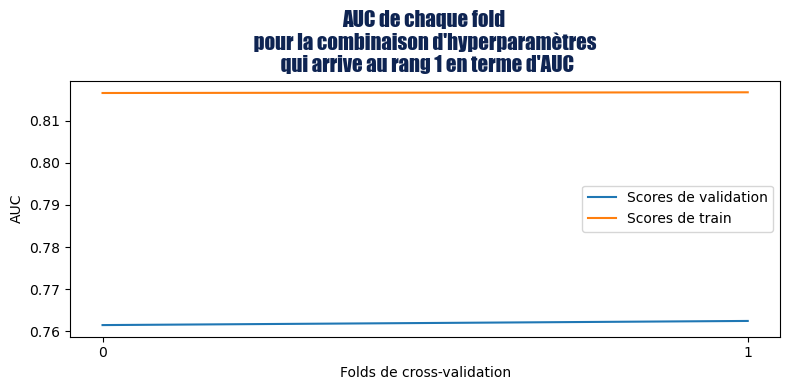

In [34]:
plot_auc_scores(best_auc_result_LGBM_3)

On constate une uniformité des résultats entre les 2 folds

In [35]:
result_lgbm_3=evaluate_model (X_train_r, y_train_r, X_val_r, y_val_r, best_model_lgbm_3)
result_lgbm_3

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.


{'predicting_execution_time': 4.14,
 'auc_train': 0.8,
 'auc_test': 0.77,
 'optimal_threshold': 0.09,
 'f1_score_1_test': 0.27,
 'recall_1_test': 0.69,
 'accuracy_test': 0.7}

La suppression des 3 variables driftées n'altèrent pas les performances du modèle qui restent absolument inchangées.

In [36]:
# Sauvegarde de l'optimal threshold dans un fichier text pour réutilisation dans le script streamlit
optimal_threshold = result_lgbm_3['optimal_threshold']

# Sauvegarde de l'optimal threshold dans un fichier texte
with open('optimal_threshold.txt', 'w') as f:
    f.write(str(optimal_threshold))


In [37]:
best_model_lgbm_3.named_steps['model']

LGBMClassifier(boosting_type='goss', colsample_bytree=0.8, max_depth=5,
               min_child_samples=500, min_child_weight=1, n_estimators=250,
               num_leaves=35, objective='binary', random_state=50,
               subsample=0.8)

In [190]:
best_model_lgbm_3.named_steps['model'].feature_name_

['EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'client_installments_AMT_PAYMENT_min_sum',
 'bureau_DAYS_CREDIT_max',
 'bureau_DAYS_CREDIT_ENDDATE_max',
 'DAYS_ID_PUBLISH',
 'client_cash_CNT_INSTALMENT_FUTURE_mean_max',
 'bureau_AMT_CREDIT_SUM_DEBT_mean',
 'OWN_CAR_AGE',
 'ANNUITY_INCOME_PERCENT',
 'bureau_DAYS_ENDDATE_FACT_max',
 'client_installments_AMT_PAYMENT_min_mean',
 'DAYS_REGISTRATION',
 'bureau_AMT_CREDIT_MAX_OVERDUE_sum',
 'DAYS_LAST_PHONE_CHANGE',
 'bureau_DAYS_CREDIT_mean',
 'previous_AMT_DOWN_PAYMENT_max',
 'client_installments_AMT_PAYMENT_min_max',
 'client_credit_CNT_DRAWINGS_CURRENT_mean_min',
 'REGION_POPULATION_RELATIVE',
 'previous_CNT_PAYMENT_mean',
 'client_cash_CNT_INSTALMENT_FUTURE_mean_mean',
 'client_installments_AMT_PAYMENT_min_min',
 'client_installments_DAYS_ENTRY_PAYMENT_sum_max',
 'client_cash_CNT_INSTALMENT_FUTURE_min_max',
 'bureau_AMT_CREDIT_SUM_mean',
 'bureau_AMT_CREDIT_SUM_max',
 'previous_SELLERPLACE_AREA_mean',

## 10.4 - Enregistrement du modèle dans MLFlow

In [38]:
# Utilisation d'un échantillon de 10 lignes comme exemple d'entrée
input_example = X_train_r.sample(n=10, random_state=42)

In [39]:
# # Création d'une nouvelle expérience MLflow
# mlflow.set_experiment("MLflow Credit_Scoring - Projet_7")

# # Commencer une session MLflow
# with mlflow.start_run():
#     # Log les hyperparameters que j'ai déclarés au dessus
#     mlflow.log_params(best_params_lgbm_3)

#     # Log les métriques
    
#     mlflow.log_metric("optimal_threshold", result_lgbm_3['optimal_threshold'])

#     mlflow.log_metric("recall_1_test", result_lgbm_3['recall_1_test'])
#     mlflow.log_metric("f1_score_1_test", result_lgbm_3['f1_score_1_test'])
#     mlflow.log_metric("accuracy du test", result_lgbm_3['accuracy_test'])
    
#     mlflow.log_metric("auc_train", result_lgbm_3['auc_train'])
#     mlflow.log_metric("auc_test", result_lgbm_3['auc_test'])
    
#     mlflow.log_metric("temps_fit", training_execution_time)
#     mlflow.log_metric("temps_predict", result_lgbm_3['predicting_execution_time'])


#     # Définir un tag pour se rappeler l'objet de cette session
#     mlflow.set_tag("Training Info", "LGBM after dropping drifted features")

#     # Infer the model signature
#     signature = infer_signature(X_train_r, best_model_lgbm_3.predict(X_train_r)) # infer_signature génère automatiquement une "signature" 
#                                                               # qui décrit les entrées et les sorties du modèle. 
#                                                               # Cela inclut les types de données et les formats attendus par le modèle, 
#                                                               # facilitant ainsi l'intégration et la réutilisation du modèle 
#                                                               # dans différents environnements.

    
#     # Log le model
#     model_info = mlflow.lightgbm.log_model(
#         lgb_model=best_model_lgbm_3.named_steps['model'], # le modèle
#         artifact_path="lgbm_classifier_model", # le chemin où le modèle sera enregistré
#         signature=signature, # la signature du modèle
#         input_example=input_example, # un exemple d'input pour montrer comment invoquer le modèle
#         registered_model_name="scoring-credit-lgbm_classifier", # nom sous lequel le modèle est enregistré dans le registre de modèles MLflow
#     )
    
#     # Afficher l'URI du modèle
#     model_uri = model_info.model_uri
#     print(f"Model URI: {model_uri}")



## 10.5 - Interprétation des résultats

### 10.5.1 - Feature Importance

In [40]:
importances = best_model_lgbm_3.named_steps['model'].feature_importances_
features= X_train_r.columns

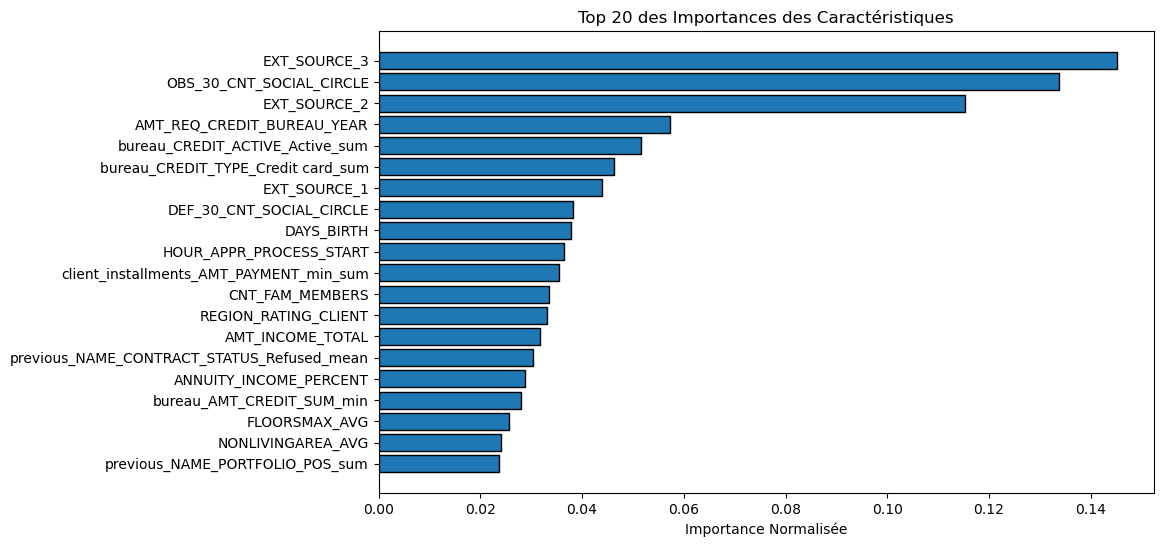

In [41]:
feature_importances_sorted=show_feature_importances(importances, features)

In [42]:
feature_importances_sorted.head(10)

,feature,importance,importance_normalized
0,EXT_SOURCE_3,307,0.145154
1,OBS_30_CNT_SOCIAL_CIRCLE,283,0.133806
2,EXT_SOURCE_2,244,0.115366
3,AMT_REQ_CREDIT_BUREAU_YEAR,121,0.057210
4,bureau_CREDIT_ACTIVE_Active_sum,109,0.051537
5,bureau_CREDIT_TYPE_Credit card_sum,98,0.046336
6,EXT_SOURCE_1,93,0.043972
7,DEF_30_CNT_SOCIAL_CIRCLE,81,0.038298
8,DAYS_BIRTH,80,0.037825
9,HOUR_APPR_PROCESS_START,77,0.036407


La suppression de CREDIT_TERM et AMT_ANNUITY fait remonter 2 nouvelles variables dans le top 10 des variables les + influentes :
- DEF_30_CNT_SOCIAL_CIRCLE :  nombre de fois où l'entourage social du client a accusé un retard de paiement de plus de 30 jours après la date d'échéance.
- HOUR_APPR_PROCESS_START : l'heure à laquelle le client a fait sa demande de prêt

### 10.5.2 - Shap Values

#### 10.5.2.1 - Interprétation globale du test

In [43]:
# on s'assure que le meilleur modèle est extrait de la pipeline
best_model=best_model_lgbm_3.named_steps['model']

In [44]:
# Initialisation de l'Explainer SHAP avec le meilleur modèle obtenu sur le jeu de données de test original
explainer = shap.Explainer(best_model)

In [45]:
# Calcul des valeurs SHAP sur les données de validation
shap_values = explainer.shap_values(X_val_r)

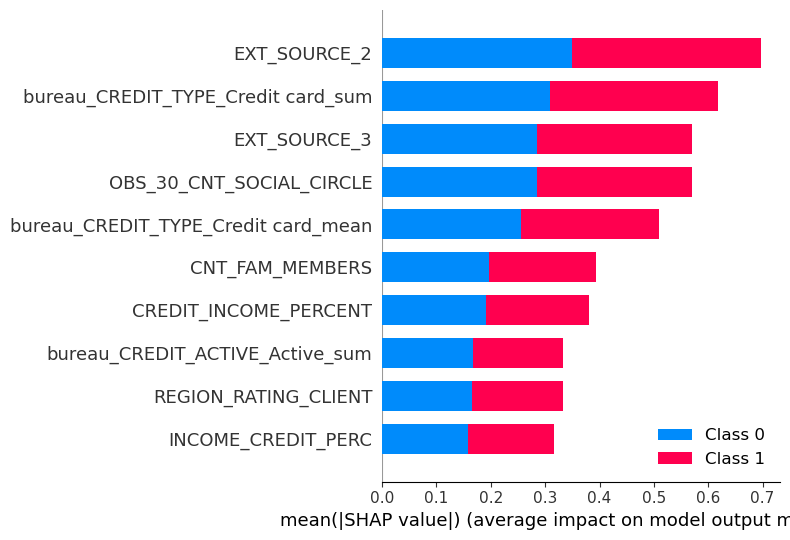

In [46]:
# Graphique récapitulatif SHAP pour l'ensemble des données transformées
shap.summary_plot(shap_values, 
                  X_val_r, 
                  plot_type="bar",
                  max_display=10)

Si on regarde ce qui se passe pour la classe 1 :

In [47]:
shap_values_class1 = shap_values[1]

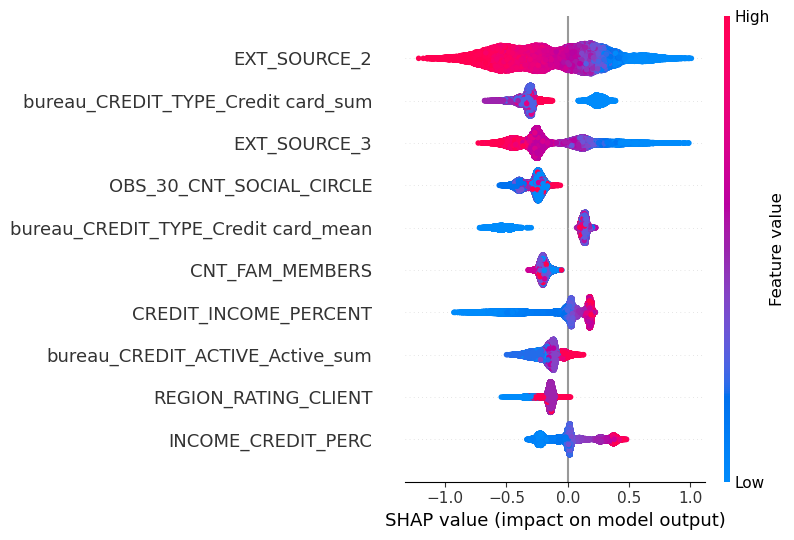

In [48]:
# Graphique récapitulatif SHAP pour la classe 1
shap.summary_plot(shap_values_class1, 
                  X_val_r, 
                  max_display=10)

Commentaires :
- Plus les variables EXT_SOURCE_2 et EXT_SOURCE_2 sont faibles, plus le client est risqué
- Plus la somme des crédit de type credit card enregistré au bureau des crédits est faible, plus le client est risqué (bureau_CREDIT_TYPE_Credit card_sum)
- A l'inverse, plus l'entourage social du client a eu des défauts de paiement dépassant de 30 jours l'échéance prévue, plus le client est risqué ('OBS_30_CNT_SOCIAL_CIRCLE'), ce qui est logique.
- Plus le taux d'endettement est élevé plus le client est risqué (CREDIT_INCOME_PERCENT)
- Plus le coefficient de remboursement est élevé, plus le client est risqué (INCOME_CREDIT_PERC)

#### 10.5.2.2 - Interprétation locale

Ajout des prédictions au set de validation :

In [49]:
# predict proba avec le best model sur le set de validation
y_val_pred_proba = best_model_lgbm_3.predict_proba(X_val_r)[:, 1]

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.


In [50]:
# Seuil optimal pour minimiser les coûts
thresholds = np.linspace(0, 1, 100)
costs = [calculate_cost_threshold(y_val_r, y_val_pred_proba, thr, cost_fn=10, cost_fp=1) for thr in thresholds]
optimal_threshold = round(thresholds[np.argmin(costs)],2) 

# Metrics at the optimal threshold
y_val_pred_opt = (y_val_pred_proba >= optimal_threshold).astype(int)

In [51]:
# verif
optimal_threshold

0.09

In [52]:
val_r['target_pred']=y_val_pred_opt
val_r['proba']=y_val_pred_proba

val_r[val_r['SK_ID_CURR']==100002]

,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,DAYS_EMPLOYED,client_installments_AMT_PAYMENT_min_sum,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_ENDDATE_max,DAYS_ID_PUBLISH,client_cash_CNT_INSTALMENT_FUTURE_mean_max,...,previous_NAME_CASH_LOAN_PURPOSE_XNA_sum,previous_CODE_REJECT_REASON_LIMIT_mean,previous_NAME_SELLER_INDUSTRY_Construction_mean,FLAG_DOCUMENT_16,NAME_INCOME_TYPE_Working,previous_NAME_GOODS_CATEGORY_Sport and Leisure_mean,TARGET,SK_ID_CURR,target_pred,proba
0,0.083037,0.262949,0.139376,9461,-637.0,175783.73,-103.0,780.0,-2120,15.0,...,0.0,0.0,0.0,0,True,0.0,1,100002,1,0.278304


In [53]:
pd.crosstab(y_val_r, y_val_pred_opt, rownames=['Classes réelles'], colnames=['Classes prédites'])

Classes prédites,0,1
Classes réelles,,
0,39606,16948
1,1518,3431


In [54]:
print(classification_report(y_val_r, y_val_pred_opt))

              precision    recall  f1-score   support

           0       0.96      0.70      0.81     56554
           1       0.17      0.69      0.27      4949

    accuracy                           0.70     61503
   macro avg       0.57      0.70      0.54     61503
weighted avg       0.90      0.70      0.77     61503



C'est ok. On retrouve les résultats énoncés précédemment (un recall de 0.69 sur la classe 1) et un seuil optimal= 0.09

Interprétation d'un individu prédit en classe 1 :

In [67]:
val_r[val_r['target_pred']==1].shape, val_r[val_r['target_pred']==0].shape

((20379, 345), (41124, 345))

In [68]:
val_r[val_r['target_pred']==1].head()

,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,DAYS_EMPLOYED,client_installments_AMT_PAYMENT_min_sum,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_ENDDATE_max,DAYS_ID_PUBLISH,client_cash_CNT_INSTALMENT_FUTURE_mean_max,...,previous_NAME_CASH_LOAN_PURPOSE_XNA_sum,previous_CODE_REJECT_REASON_LIMIT_mean,previous_NAME_SELLER_INDUSTRY_Construction_mean,FLAG_DOCUMENT_16,NAME_INCOME_TYPE_Working,previous_NAME_GOODS_CATEGORY_Sport and Leisure_mean,TARGET,SK_ID_CURR,target_pred,proba
245895,0.675878,0.604894,0.000527,13297,-762.0,30195.406,-129.0,231.0,-4307,6.00,...,1.0,0.000000,0.0,0,False,0.0,0,384575,1,0.164720
36463,0.527239,0.531760,0.207964,17907,-639.0,77640.880,-399.0,1189.0,-1461,5.00,...,3.0,0.000000,0.0,0,True,0.0,0,142232,1,0.214799
226343,NaN,0.519127,0.104795,19130,NaN,374056.030,-154.0,211.0,-959,17.50,...,1.0,0.000000,0.0,0,False,0.0,0,362171,1,0.236978
181469,NaN,0.012588,0.490258,10801,-260.0,NaN,-557.0,904.0,-3152,NaN,...,NaN,NaN,NaN,0,False,NaN,0,310328,1,0.238657
29765,0.345717,0.412734,0.639708,13280,-280.0,131626.360,-775.0,1051.0,-4880,5.75,...,0.0,0.333333,0.0,0,False,0.0,1,134561,1,0.091764


In [69]:
# Choix de l'ID de l'individu à analyser parmi tous ceux qui ont une prédiction de classe 1
specific_id = 384575

In [70]:
# Trouver l'index de cet individu dans le jeu de données de test
index = val_r[val_r['SK_ID_CURR'] == specific_id].index[0]

In [71]:
# Réinitialiser les index de X_test_r pour obtenir des index consécutifs
X_val_r_reset = X_val_r.reset_index(drop=True)

# Réinitialiser les index de test_r pour obtenir des index consécutifs
val_r_reset = val_r.reset_index(drop=True)

Cette étape assure que les index sont consécutifs et commencent à 0, ce qui facilite l'alignement.

In [72]:
# Trouver le nouvel index relatif dans le jeu de données réinitialisé
relative_index = val_r_reset[val_r_reset['SK_ID_CURR'] == specific_id].index[0]

Cette ligne de code trouve l'index relatif de l'individu spécifique dans test_r_reset.

In [73]:
# Vérifier les dimensions de shap_values et X_test_r_reset 
print("Dimensions des shap_values pour la classe 1:", shap_values[1].shape)
print("Dimensions de X_test_r_reset:", X_val_r_reset.shape)

Dimensions des shap_values pour la classe 1: (61503, 341)
Dimensions de X_test_r_reset: (61503, 341)


In [74]:
# Extraire les valeurs SHAP pour cet individu spécifique pour la classe 1
individual_shap_values = shap_values[1][relative_index]

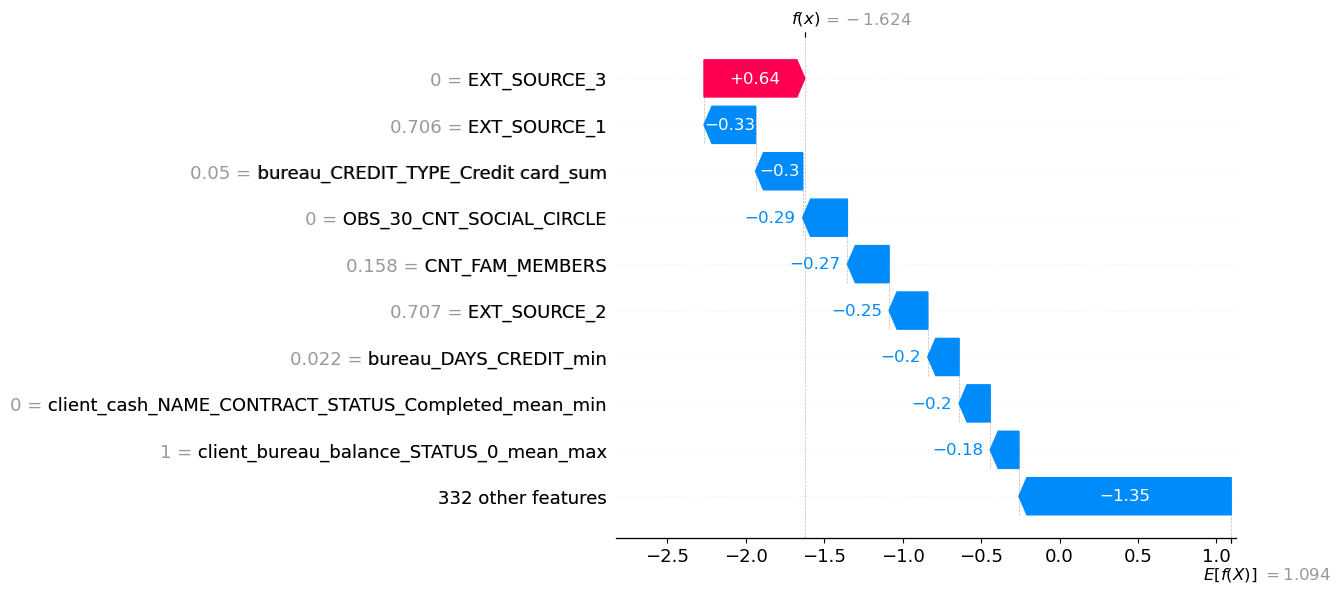

In [75]:
# Créer le graphique waterfall pour cet individu
shap.plots.waterfall(shap.Explanation(values=individual_shap_values,
                                      base_values=explainer.expected_value[1],  # choix de la bonne valeur de base
                                      data=X_val_r_reset.iloc[relative_index],  # Données de l'individu
                                      feature_names=X_val_r_reset.columns.tolist()))  # Noms des caractéristiques

Interprétation d'un individu prédit en classe 0

In [76]:
val_r[val_r['target_pred']==0].head()

,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,DAYS_EMPLOYED,client_installments_AMT_PAYMENT_min_sum,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_ENDDATE_max,DAYS_ID_PUBLISH,client_cash_CNT_INSTALMENT_FUTURE_mean_max,...,previous_NAME_CASH_LOAN_PURPOSE_XNA_sum,previous_CODE_REJECT_REASON_LIMIT_mean,previous_NAME_SELLER_INDUSTRY_Construction_mean,FLAG_DOCUMENT_16,NAME_INCOME_TYPE_Working,previous_NAME_GOODS_CATEGORY_Sport and Leisure_mean,TARGET,SK_ID_CURR,target_pred,proba
98194,0.430827,0.425351,0.712155,14778,-1141.0,1345559.400,-295.0,9479.0,-4546,7.666666,...,7.0,0.083333,0.0,0,False,0.0,0,214010,0,0.059015
249923,NaN,0.693521,0.614414,19626,-6982.0,231.660,-2185.0,-2004.0,-3158,3.120000,...,0.0,0.000000,0.0,0,False,0.0,0,389171,0,0.040601
158389,0.654882,0.560690,0.636376,20327,-1105.0,98562.734,-217.0,1609.0,-494,8.250000,...,5.0,0.000000,0.0,0,True,0.0,0,283617,0,0.068437
69571,0.714067,0.547963,NaN,15722,-345.0,NaN,-727.0,-631.0,-4672,NaN,...,NaN,NaN,NaN,0,False,NaN,0,180689,0,0.046072
114736,NaN,0.077535,0.633032,23516,NaN,761519.200,-354.0,741.0,-4763,15.529411,...,9.0,0.000000,0.0,0,False,0.0,0,233043,0,0.035589


In [77]:
# ID de l'individu à analyser
specific_id = 214010

In [78]:
# Trouver l'index de cet individu dans le jeu de données de test
index = val_r[val_r['SK_ID_CURR'] == specific_id].index[0]

In [79]:
# Réinitialiser les index de X_test_r pour obtenir des index consécutifs
X_val_r_reset = X_val_r.reset_index(drop=True)

# Réinitialiser les index de test_r pour obtenir des index consécutifs
val_r_reset = val_r.reset_index(drop=True)

In [80]:
# Trouver le nouvel index relatif dans le jeu de données réinitialisé
relative_index = val_r_reset[val_r_reset['SK_ID_CURR'] == specific_id].index[0]

In [81]:
# Extraire les valeurs SHAP pour cet individu spécifique pour la classe 0
individual_shap_values = shap_values[0][relative_index]

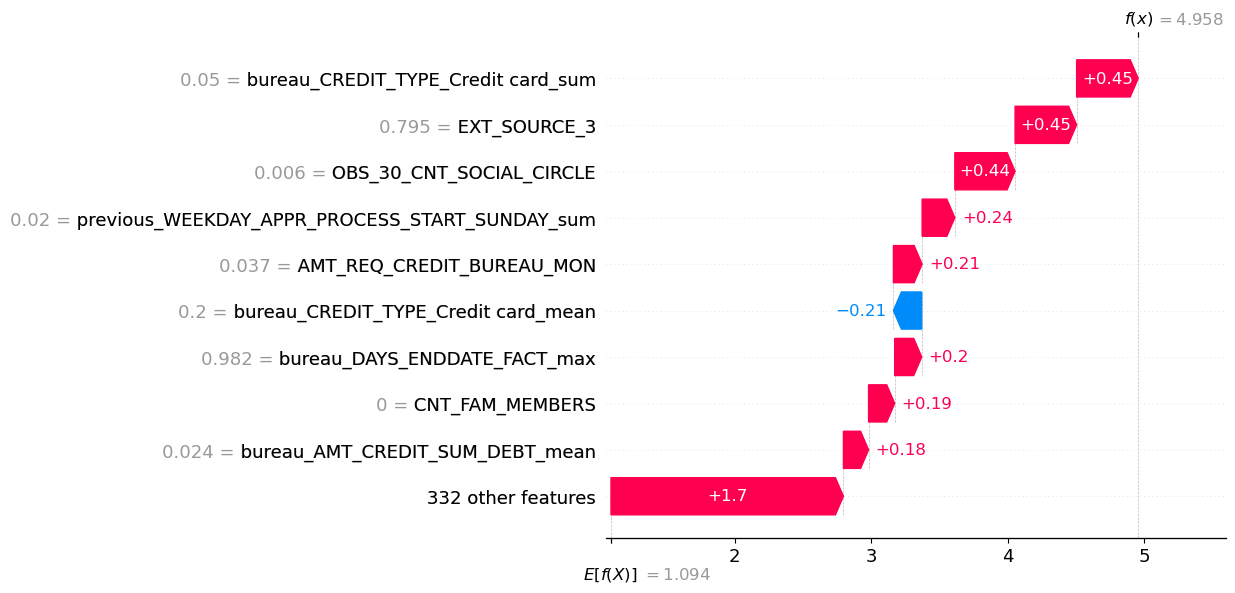

In [82]:
# Créer le graphique waterfall pour cet individu
shap.plots.waterfall(shap.Explanation(values=individual_shap_values,
                                      base_values=explainer.expected_value[1],  # choix de la bonne valeur de base
                                      data=X_val_r_reset.iloc[relative_index],  # Données de l'individu
                                      feature_names=X_val_r_reset.columns.tolist()))  # Noms des caractéristiques

Creation d'une fonction pour utilisation ultérieure dans le script streamlit:

In [83]:
def generate_shap_waterfall(specific_id, shap_values, test_r, explainer, X_test_r):
    """
    Génère un graphique waterfall SHAP pour un individu spécifié par son ID.
    
    Parameters:
    - specific_id : int
        L'ID de l'individu pour lequel générer le graphique.
    - shap_values : list of numpy arrays
        Les valeurs SHAP pour les classes, typiquement [shap_values_class0, shap_values_class1].
    - test_r : DataFrame
        Le DataFrame contenant les identifiants des individus et les prédictions.
    - explainer : shap.Explainer
        L'explainer SHAP utilisé pour calculer les valeurs SHAP.
    - X_test_r : DataFrame
        Le DataFrame des données de test sur lequel les valeurs SHAP ont été calculées.
    """
    # Trouver l'index de l'individu dans le jeu de données de test
    index = test_r[test_r['SK_ID_CURR'] == specific_id].index[0]

    # Réinitialiser les index de X_test_r pour obtenir des index consécutifs
    X_test_r_reset = X_test_r.reset_index(drop=True)

    # Réinitialiser les index de test_r pour obtenir des index consécutifs
    test_r_reset = test_r.reset_index(drop=True)

    # Trouver le nouvel index relatif dans le jeu de données réinitialisé
    relative_index = test_r_reset[test_r_reset['SK_ID_CURR'] == specific_id].index[0]

    # Extraire les valeurs SHAP pour cet individu spécifique
    predicted_class = test_r.loc[test_r.index[relative_index], 'target_pred']
    individual_shap_values = shap_values[predicted_class][relative_index]

    # Créer le graphique waterfall pour cet individu
    shap.plots.waterfall(shap.Explanation(values=individual_shap_values,
                                          base_values=explainer.expected_value[predicted_class],  # Assurez-vous de choisir la bonne valeur de base
                                          data=X_test_r_reset.iloc[relative_index],  # Données de l'individu
                                          feature_names=X_test_r_reset.columns.tolist()))  # Noms des caractéristiques


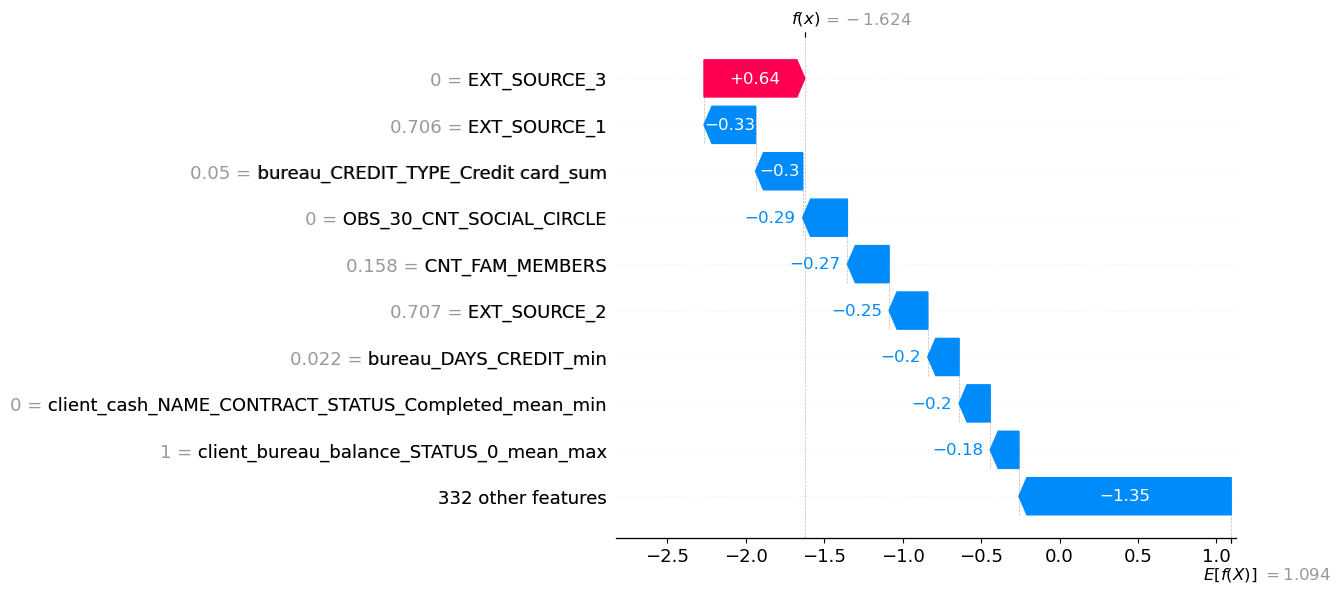

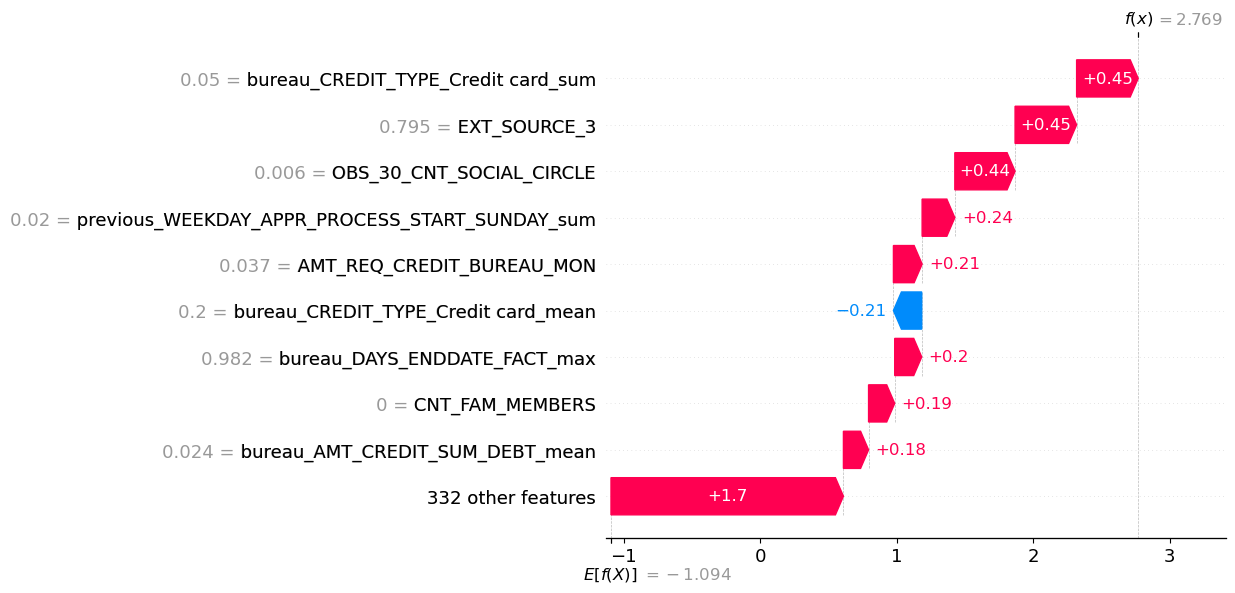

In [84]:
# Pour un individu prédit en classe 1
generate_shap_waterfall(384575, shap_values, val_r, explainer, X_val_r)

# Pour un individu prédit en classe 0
generate_shap_waterfall(214010, shap_values, val_r, explainer, X_val_r)

CONCLUSION : la suppression des variables AMT_CREDIT, AMT_ANNUITY, CREDIT_TERM n'a pas affecté la performance du modèle

Pour la suite, je me suis basée sur : https://app.livestorm.co/openclassrooms-1/deployez-une-api-de-prediction/live?s=021e19b0-cd31-4872-8b6f-b71209d05664#/chat

# 11 - Sérialisation du modèle
----------

Sérialisation = le fait de convertir un objet qui est stocké de façon numérique sur notre mémoire ram. et le stocker sous forme de binaire sur notre ordinateur. 

La pipeline était dans notre mémoire vive. On veut la stocker sous forme de fichier pour pouvoir la réutiliser plus tard

On peut sérialiser en pickle ou en joblib. Avec Scikit Learn, on recommande joblib

In [85]:
import joblib

In [86]:
joblib.dump(best_model_lgbm_3, 'credit_scoring_new.joblib')

['credit_scoring_new.joblib']

# 12 - Inférence sur le jeu de test
-----------

Préparation du script Streamlit en utilisant le modèle enregistré en .joblib pour faire les prédictions sur le jeu de test

In [87]:
# Chargement du modèle
model_pipeline = joblib.load("credit_scoring_new.joblib")

In [88]:
# Extraction du modèle LGBM de la pipeline
model = model_pipeline.named_steps['model']

In [189]:
model_pipeline.named_steps['model'].feature_name_

['EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'client_installments_AMT_PAYMENT_min_sum',
 'bureau_DAYS_CREDIT_max',
 'bureau_DAYS_CREDIT_ENDDATE_max',
 'DAYS_ID_PUBLISH',
 'client_cash_CNT_INSTALMENT_FUTURE_mean_max',
 'bureau_AMT_CREDIT_SUM_DEBT_mean',
 'OWN_CAR_AGE',
 'ANNUITY_INCOME_PERCENT',
 'bureau_DAYS_ENDDATE_FACT_max',
 'client_installments_AMT_PAYMENT_min_mean',
 'DAYS_REGISTRATION',
 'bureau_AMT_CREDIT_MAX_OVERDUE_sum',
 'DAYS_LAST_PHONE_CHANGE',
 'bureau_DAYS_CREDIT_mean',
 'previous_AMT_DOWN_PAYMENT_max',
 'client_installments_AMT_PAYMENT_min_max',
 'client_credit_CNT_DRAWINGS_CURRENT_mean_min',
 'REGION_POPULATION_RELATIVE',
 'previous_CNT_PAYMENT_mean',
 'client_cash_CNT_INSTALMENT_FUTURE_mean_mean',
 'client_installments_AMT_PAYMENT_min_min',
 'client_installments_DAYS_ENTRY_PAYMENT_sum_max',
 'client_cash_CNT_INSTALMENT_FUTURE_min_max',
 'bureau_AMT_CREDIT_SUM_mean',
 'bureau_AMT_CREDIT_SUM_max',
 'previous_SELLERPLACE_AREA_mean',

In [89]:
# Chargement des données de test reconstituées
jeu_de_test=pd.read_csv('reconstituted_test_sampled.csv')
jeu_de_test.head()

,SK_ID_CURR,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,DAYS_EMPLOYED,client_installments_AMT_PAYMENT_min_sum,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_ENDDATE_max,DAYS_ID_PUBLISH,...,client_credit_AMT_INST_MIN_REGULARITY_sum_sum,previous_NAME_GOODS_CATEGORY_Gardening_mean,client_installments_NUM_INSTALMENT_NUMBER_min_max,ORGANIZATION_TYPE_Business Entity Type 3,previous_NAME_CASH_LOAN_PURPOSE_XNA_sum,previous_CODE_REJECT_REASON_LIMIT_mean,previous_NAME_SELLER_INDUSTRY_Construction_mean,FLAG_DOCUMENT_16,NAME_INCOME_TYPE_Working,previous_NAME_GOODS_CATEGORY_Sport and Leisure_mean
0,208550,0.664307,0.902796,0.599166,0.217531,0.935853,0.055533,0.896988,0.585400,0.450743,...,0.004138,0.0,0.0,1.0,0.000000,0.000000,0.0,0.0,1.0,0.0
1,173779,0.524898,0.786010,0.619130,0.696900,0.908106,0.033502,0.997262,0.697944,0.550229,...,0.004138,0.0,0.0,0.0,0.068966,0.111111,0.0,0.0,0.0,0.0
2,365820,0.826955,0.737094,0.691248,0.431172,0.726943,0.090487,0.645791,0.558941,0.381687,...,0.000000,0.0,0.0,1.0,0.068966,0.000000,0.0,0.0,0.0,0.0
3,144092,0.475811,0.902102,0.457380,0.435457,0.845188,0.092695,0.904860,0.575216,0.313186,...,0.004465,0.0,0.0,0.0,0.068966,0.000000,0.0,0.0,1.0,0.0
4,291599,0.353510,0.560834,0.599166,0.468828,0.675301,0.033505,0.896988,0.585400,0.174239,...,0.004138,0.0,0.0,0.0,0.068966,0.000000,0.0,0.0,1.0,0.0


In [188]:
jeu_de_test['NAME_EDUCATION_TYPE_Higher education'].unique()

array([1., 0.])

In [90]:
# Fonction pour générer des prédictions
def generate_predictions(input_data, threshold):
    prediction_proba = model_pipeline.predict_proba(input_data)[:, 1]
    prediction = (prediction_proba >= threshold).astype(int)
    return prediction_proba, prediction

In [91]:
# Chargement de l'optimal_threshold depuis le fichier texte
with open('optimal_threshold.txt', 'r') as f:
    optimal_threshold = float(f.read().strip())

## 12.1 - Prédictions sur l'ensemble du jeu de test 

Pour faire des contrôles ultérieurs sur le fonctionnement de l'application Streamlit

In [92]:
# Prediction sur l'ensemble du jeu de test
all_prediction_proba, all_prediction=generate_predictions(jeu_de_test.iloc[:, 1:],  optimal_threshold)

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.


In [93]:
# Ajout des prédictions au dataframe
jeu_de_test['predict_proba']=all_prediction_proba
jeu_de_test['predictions']=all_prediction

In [94]:
# Filtrage des clients scorés 0
jeu_de_test[jeu_de_test['predictions']==0].sort_values(by='predict_proba').head(5)


,SK_ID_CURR,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,DAYS_EMPLOYED,client_installments_AMT_PAYMENT_min_sum,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_ENDDATE_max,DAYS_ID_PUBLISH,...,client_installments_NUM_INSTALMENT_NUMBER_min_max,ORGANIZATION_TYPE_Business Entity Type 3,previous_NAME_CASH_LOAN_PURPOSE_XNA_sum,previous_CODE_REJECT_REASON_LIMIT_mean,previous_NAME_SELLER_INDUSTRY_Construction_mean,FLAG_DOCUMENT_16,NAME_INCOME_TYPE_Working,previous_NAME_GOODS_CATEGORY_Sport and Leisure_mean,predict_proba,predictions
4078,441463,0.642169,0.784831,0.823570,0.715107,0.908106,0.137825,0.800821,0.589986,0.657218,...,0.0,0.0,0.017241,0.0,0.0,0.0,0.0,0.0,0.001713,0
3929,283816,0.746172,0.776143,0.788042,0.638162,0.797231,0.122493,0.571184,0.557901,0.675281,...,0.0,0.0,0.051724,0.0,0.0,0.0,1.0,0.0,0.001964,0
1265,182305,0.524898,0.880832,0.932737,0.516629,0.718457,0.058140,0.374743,0.552946,0.971099,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.002057,0
1186,154043,0.524898,0.785914,0.758934,0.564938,0.452490,0.036062,0.578713,0.995743,0.852716,...,0.0,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.002069,0
1059,204403,0.797246,0.907126,0.844843,0.608005,0.393703,0.031282,0.909651,0.583498,0.750174,...,0.0,0.0,0.000000,0.0,0.5,0.0,1.0,0.0,0.002150,0


In [95]:
jeu_de_test[jeu_de_test['predictions']==0].sort_values(by='predict_proba').tail(5)

,SK_ID_CURR,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,DAYS_EMPLOYED,client_installments_AMT_PAYMENT_min_sum,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_ENDDATE_max,DAYS_ID_PUBLISH,...,client_installments_NUM_INSTALMENT_NUMBER_min_max,ORGANIZATION_TYPE_Business Entity Type 3,previous_NAME_CASH_LOAN_PURPOSE_XNA_sum,previous_CODE_REJECT_REASON_LIMIT_mean,previous_NAME_SELLER_INDUSTRY_Construction_mean,FLAG_DOCUMENT_16,NAME_INCOME_TYPE_Working,previous_NAME_GOODS_CATEGORY_Sport and Leisure_mean,predict_proba,predictions
2841,279265,0.405006,0.785198,0.554943,0.409357,0.974431,0.029254,0.979124,0.996208,0.962068,...,0.000000,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.089900,0
4355,411012,0.507151,0.740189,0.445736,0.461161,0.894931,0.003880,0.882272,0.593244,0.388217,...,0.000000,1.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.089924,0
3507,365991,0.403410,0.340817,0.159948,0.597238,0.976217,0.032422,0.725188,0.586961,0.771016,...,0.000000,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.089954,0
3676,135041,0.524898,0.590622,0.788042,0.895152,0.908106,0.017543,0.943190,0.995729,0.401973,...,0.000000,0.0,0.051724,0.0,0.0,0.0,0.0,0.0,0.089976,0
3372,142803,0.524898,0.615225,0.160942,0.699831,0.466670,0.000921,0.988022,0.995894,0.524524,...,0.083969,0.0,0.051724,0.0,0.0,0.0,0.0,0.0,0.089993,0


In [96]:
# Filtrage des clients scorés 1
jeu_de_test[jeu_de_test['predictions']==1].sort_values(by='predict_proba').head(5)


,SK_ID_CURR,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,DAYS_EMPLOYED,client_installments_AMT_PAYMENT_min_sum,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_ENDDATE_max,DAYS_ID_PUBLISH,...,client_installments_NUM_INSTALMENT_NUMBER_min_max,ORGANIZATION_TYPE_Business Entity Type 3,previous_NAME_CASH_LOAN_PURPOSE_XNA_sum,previous_CODE_REJECT_REASON_LIMIT_mean,previous_NAME_SELLER_INDUSTRY_Construction_mean,FLAG_DOCUMENT_16,NAME_INCOME_TYPE_Working,previous_NAME_GOODS_CATEGORY_Sport and Leisure_mean,predict_proba,predictions
4748,200493,0.578606,0.255205,0.560984,0.516347,0.872934,0.012541,0.747091,0.572835,0.973044,...,0.000000,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.090127,1
3897,379502,0.322912,0.679826,0.700699,0.274014,0.947019,0.028578,0.649213,0.577858,0.316521,...,0.015267,0.0,0.068966,0.0,0.0,0.0,1.0,0.0,0.090198,1
3971,408662,0.200451,0.645172,0.627074,0.281905,0.946795,0.008610,0.907255,0.588412,0.328192,...,0.000000,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.090239,1
3569,202252,0.524898,0.455908,0.522771,0.194025,0.911512,0.029782,0.909993,0.579364,0.600111,...,0.000000,0.0,0.034483,0.0,0.0,0.0,1.0,0.0,0.090305,1
1475,190767,0.524898,0.488338,0.822010,0.193799,0.992296,0.007314,0.808008,0.588371,0.586633,...,0.000000,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.090308,1


In [97]:
jeu_de_test[jeu_de_test['predictions']==1].sort_values(by='predict_proba').tail(5)


,SK_ID_CURR,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,DAYS_EMPLOYED,client_installments_AMT_PAYMENT_min_sum,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_ENDDATE_max,DAYS_ID_PUBLISH,...,client_installments_NUM_INSTALMENT_NUMBER_min_max,ORGANIZATION_TYPE_Business Entity Type 3,previous_NAME_CASH_LOAN_PURPOSE_XNA_sum,previous_CODE_REJECT_REASON_LIMIT_mean,previous_NAME_SELLER_INDUSTRY_Construction_mean,FLAG_DOCUMENT_16,NAME_INCOME_TYPE_Working,previous_NAME_GOODS_CATEGORY_Sport and Leisure_mean,predict_proba,predictions
631,118127,0.053039,0.254482,0.420865,0.531962,0.943948,0.004709,0.059206,0.537820,0.933861,...,0.0,1.0,0.017241,0.000000,0.0,0.0,0.0,0.0,0.601846,1
3852,232428,0.107967,0.272963,0.257863,0.136979,0.963042,0.015429,0.945585,0.995948,0.644296,...,0.0,1.0,0.103448,0.000000,0.0,0.0,0.0,0.0,0.609483,1
1242,141215,0.028997,0.075769,0.599166,0.167756,0.960418,0.007844,0.896988,0.585400,0.793803,...,0.0,1.0,0.034483,0.000000,0.0,0.0,1.0,0.0,0.696562,1
1819,323108,0.524898,0.005568,0.281492,0.393292,0.909223,0.022329,0.929158,0.702502,0.398083,...,0.0,0.0,0.017241,0.333333,0.0,0.0,1.0,0.0,0.717731,1
929,265895,0.241410,0.015863,0.100162,0.418489,0.954779,0.009859,0.950034,0.596036,0.952341,...,0.0,1.0,0.051724,0.125000,0.0,0.0,1.0,0.0,0.767556,1


## 12.2 - Prédiction sur un individu en particulier

Pour préparer l'écriture du script Streamlit 

In [98]:
# Sélection de l'individu le mieux scoré par son Id et récupération de toutes les variables 
# sauf la 1ère (qui correspond à l'ID) et les 2 dernières qui correspondent aux predictions
selec_indiv=jeu_de_test[jeu_de_test['SK_ID_CURR']==441463].iloc[:, 1:-2]
selec_indiv

,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,DAYS_EMPLOYED,client_installments_AMT_PAYMENT_min_sum,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_ENDDATE_max,DAYS_ID_PUBLISH,client_cash_CNT_INSTALMENT_FUTURE_mean_max,...,client_credit_AMT_INST_MIN_REGULARITY_sum_sum,previous_NAME_GOODS_CATEGORY_Gardening_mean,client_installments_NUM_INSTALMENT_NUMBER_min_max,ORGANIZATION_TYPE_Business Entity Type 3,previous_NAME_CASH_LOAN_PURPOSE_XNA_sum,previous_CODE_REJECT_REASON_LIMIT_mean,previous_NAME_SELLER_INDUSTRY_Construction_mean,FLAG_DOCUMENT_16,NAME_INCOME_TYPE_Working,previous_NAME_GOODS_CATEGORY_Sport and Leisure_mean
4078,0.642169,0.784831,0.82357,0.715107,0.908106,0.137825,0.800821,0.589986,0.657218,0.060976,...,0.004138,0.0,0.0,0.0,0.017241,0.0,0.0,0.0,0.0,0.0


In [99]:
# Prédictions pour l'individu sélectionné
prediction_proba, prediction = generate_predictions(selec_indiv, optimal_threshold)

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.


In [100]:
prediction_proba

array([0.00171272])

In [101]:
prediction

array([0])

In [102]:
# Shap pour explication de la classe 1

def display_shap_values(model, input_data):
    explainer = shap.Explainer(model)
    individual_shap = explainer.shap_values(input_data)
    shap_values_for_class_1 = individual_shap[1]
    waterfallplot = shap.plots.waterfall(shap.Explanation(values=shap_values_for_class_1[0], 
                                          base_values=explainer.expected_value[1], 
                                          data=input_data.iloc[0], 
                                          feature_names=input_data.columns.tolist()), show=False)
    return waterfallplot

In [103]:
waterfallplot=display_shap_values(model, selec_indiv)

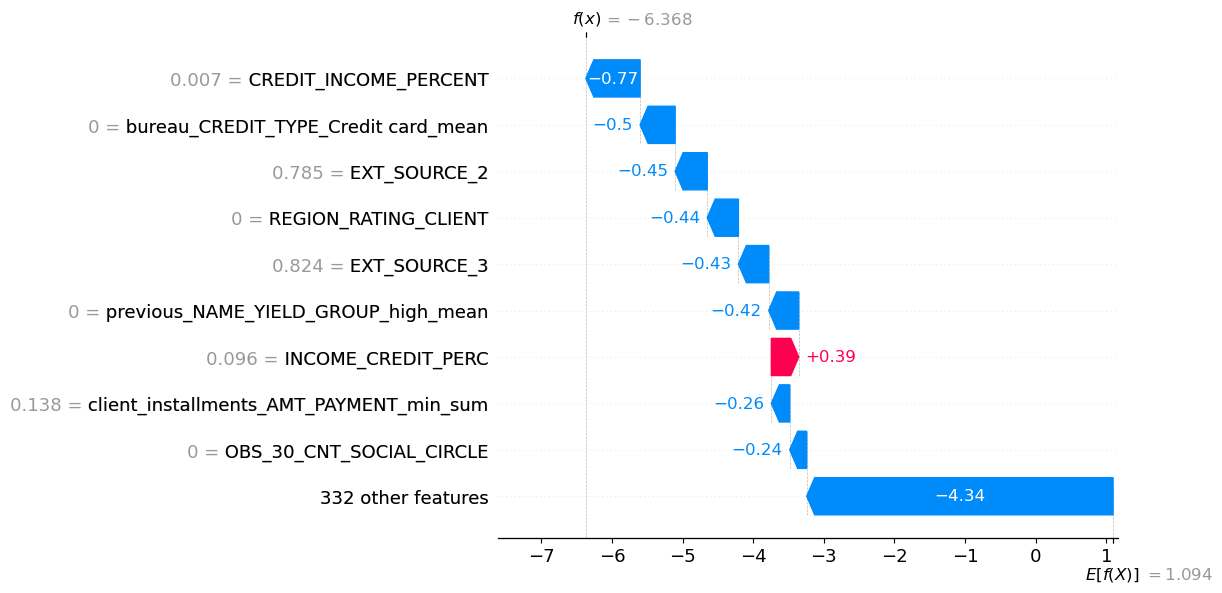

In [104]:
plt.show()

In [105]:
# Sélection de l'individu le moins bien scoré par son Id et récupération de toutes les variables 
# sauf la 1ère (qui correspond à l'ID) et les 2 dernières qui correspondent aux predictions

selec_indiv=jeu_de_test[jeu_de_test['SK_ID_CURR']==265895].iloc[:, 1:-2]
selec_indiv

,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,DAYS_EMPLOYED,client_installments_AMT_PAYMENT_min_sum,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_ENDDATE_max,DAYS_ID_PUBLISH,client_cash_CNT_INSTALMENT_FUTURE_mean_max,...,client_credit_AMT_INST_MIN_REGULARITY_sum_sum,previous_NAME_GOODS_CATEGORY_Gardening_mean,client_installments_NUM_INSTALMENT_NUMBER_min_max,ORGANIZATION_TYPE_Business Entity Type 3,previous_NAME_CASH_LOAN_PURPOSE_XNA_sum,previous_CODE_REJECT_REASON_LIMIT_mean,previous_NAME_SELLER_INDUSTRY_Construction_mean,FLAG_DOCUMENT_16,NAME_INCOME_TYPE_Working,previous_NAME_GOODS_CATEGORY_Sport and Leisure_mean
929,0.24141,0.015863,0.100162,0.418489,0.954779,0.009859,0.950034,0.596036,0.952341,0.085366,...,0.004138,0.0,0.0,1.0,0.051724,0.125,0.0,0.0,1.0,0.0


In [106]:
# Prédictions pour l'individu sélectionné
prediction_proba, prediction = generate_predictions(selec_indiv, optimal_threshold)

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.


In [107]:
prediction_proba

array([0.76755584])

In [108]:
prediction

array([1])

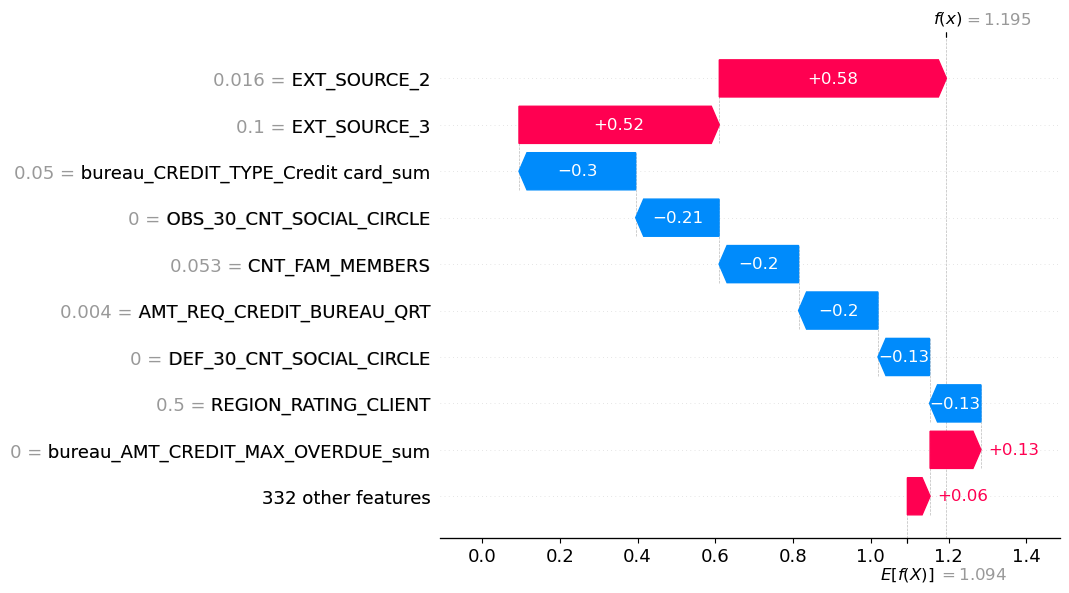

In [116]:
waterfallplot=display_shap_values(model, selec_indiv)
plt.show()

Pour préparer les test unitaires, je m'assure que la somme de la base value + les shap values me donne bien la prédiction (après utilisation de la fonction logistique). Toujours pour l'individu '265895'

In [134]:
# Initialisation de l'Explainer SHAP
explainer = shap.Explainer(model)
explainer

In [135]:
# Calcul des valeurs SHAP pour l'individu sélectionné
shap_values = explainer.shap_values(selec_indiv)
shap_values

[array([[-1.27453555e-01, -5.84298620e-01, -5.15409593e-01,
         -8.14692033e-02, -8.33885829e-02, -5.86892155e-02,
          4.31448571e-03, -7.87242952e-03, -8.99904481e-02,
          2.18038706e-02, -1.68497590e-02, -1.43915794e-02,
         -7.28435404e-02, -2.81817291e-02,  4.96693038e-03,
         -1.06198150e-02, -1.30893809e-01, -2.10204298e-02,
         -1.39683946e-03,  3.09981368e-02, -3.39010917e-03,
          3.14654673e-03, -1.19077690e-02,  7.47998549e-03,
          7.17004042e-03, -3.35222000e-02,  3.26509036e-04,
          2.63256538e-02,  3.35626624e-03,  1.19754568e-02,
         -2.34579263e-06,  1.00776784e-04, -8.02844965e-03,
          1.60701883e-02, -3.85498149e-02, -1.93417155e-02,
         -5.49745538e-03, -1.12692854e-01,  2.42430685e-03,
         -8.63002495e-03, -9.54989538e-04, -5.71678813e-03,
          4.13465250e-04,  1.33050158e-02, -1.56309148e-03,
         -1.53845671e-03,  3.32940952e-04,  6.15096943e-04,
          1.19182662e-02, -1.20493726e-0

In [136]:
# Extraire les valeurs SHAP pour la classe 1
individual_shap_values = shap_values[1][0]
individual_shap_values

array([ 1.27453555e-01,  5.84298620e-01,  5.15409593e-01,  8.14692033e-02,
        8.33885829e-02,  5.86892155e-02, -4.31448571e-03,  7.87242952e-03,
        8.99904481e-02, -2.18038706e-02,  1.68497590e-02,  1.43915794e-02,
        7.28435404e-02,  2.81817291e-02, -4.96693038e-03,  1.06198150e-02,
        1.30893809e-01,  2.10204298e-02,  1.39683946e-03, -3.09981368e-02,
        3.39010917e-03, -3.14654673e-03,  1.19077690e-02, -7.47998549e-03,
       -7.17004042e-03,  3.35222000e-02, -3.26509036e-04, -2.63256538e-02,
       -3.35626624e-03, -1.19754568e-02,  2.34579263e-06, -1.00776784e-04,
        8.02844965e-03, -1.60701883e-02,  3.85498149e-02,  1.93417155e-02,
        5.49745538e-03,  1.12692854e-01, -2.42430685e-03,  8.63002495e-03,
        9.54989538e-04,  5.71678813e-03, -4.13465250e-04, -1.33050158e-02,
        1.56309148e-03,  1.53845671e-03, -3.32940952e-04, -6.15096943e-04,
       -1.19182662e-02,  1.20493726e-02,  2.73917058e-02, -6.08458038e-03,
        3.62205199e-02,  

In [137]:
# Calculer la somme des valeurs SHAP
shap_sum = individual_shap_values.sum()
shap_sum

0.10037330534196909

In [138]:
# Obtenir la base value pour la classe 1
base_value = explainer.expected_value[1]
base_value

1.094187884715776

In [133]:
# Calculer la prédiction en utilisant la fonction logistique (sigmoïde)
log_odds = base_value + shap_sum
predicted_value_proba = expit(log_odds)  # Utilisation de la fonction logistique pour obtenir la probabilité


In [139]:
print(f"Base value: {base_value}")
print(f"Somme des SHAP values: {shap_sum}")
print(f"Log-odds: {log_odds}")
print(f"Prédiction calculée (probabilité): {predicted_value_proba}")
print(f"Prédiction du modèle: {prediction_proba[0]}")

Base value: 1.094187884715776
Somme des SHAP values: 0.10037330534196909
Log-odds: 1.194561190057745
Prédiction calculée (probabilité): 0.767555836731656
Prédiction du modèle: 0.7675558367316557


C'est ok

# 13 - Déploiement du modèle en local avec Streamlit
--------

0 - Commencer par pusher vers Github tout le travail qui a été fait.
/!\ Penser à faire un .gitignore pour ne pas pusher tous les fichiers parasite
/!\ Penser aussi à faire le fichier requirements avec toutes les librairies utilisées

1 - Ouvrir Anaconda Prompt : taper directement mlflow server --host 127.0.0.1 --port 8080 si ça n'a pas déjà été fait

2 - Ecriture du script streamlit : app_streamlit_joblib.py (on l'écrit dans le bloc note et on l'enregistre en .py dans le dossier "C:\Users\belou\Projet 7 bis\projet_7")

3 - Ouvrir un nouveau Prompt Anaconda  : avec la commande cd, se positionner ici : "C:\Users\belou\Projet 7 bis\projet_7" en copiant le chemin d'accès. Puis taper : streamlit run app_streamlit_joblib.py => ca ouvre l'application  en local

4 - Cliquer sur le bouton 'deploy' en haut à droite de la page streamlit => bascule dans share.streamlit.io

5 - J'ai suivi ce tuto : https://docs.streamlit.io/deploy/streamlit-community-cloud/get-started/quickstart (je ne suis pas passée par Google mais directement via mon compte Github) :
- une fois que j'ai cliqué sur le bouton 'deploy' donc, j'ai choisi de déployer dans le streamlit community cloud (et pas custom deployment)
- j'ai renseigné le nom du repository : Dabele44/credit_scoring_pret_a_depenser
- la branch : main
- le main file path : app_streamlit_joblib.py


Voici l'adresse publique de mon app : https://dabele44-credit-scoring-pret-a-depe-app-streamlit-joblib-yq1wpc.streamlit.app/